In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from training.model_training import NN, get_loaders, get_accuracy
from interface.interfacer import PseudoHardwareNN

from hardware.crossbars import SimpleCrossbar

In [8]:
model_path = "training/model.pth"

device = "cpu" # need to fix for cuda and mps

software_nn = NN()
hardware_nn = PseudoHardwareNN(hardware_multiplier=SimpleCrossbar)
hardware_quantized_nn = PseudoHardwareNN(hardware_multiplier=SimpleCrossbar, input_quantization=(True, 0.1), weight_quantization=(True, 0.05, [1e-6,1]), output_quantization=(True, 0.1))

# load weights
software_nn.load_state_dict(torch.load(model_path))
hardware_nn.load_state_dict(torch.load(model_path))
hardware_quantized_nn.load_state_dict(torch.load(model_path))

# set device
software_nn.to(device)
hardware_nn.to(device)
hardware_quantized_nn.to(device)

# dataset
test_data = get_loaders(batch_size=1, train=False, dataset_path="datasets/")

# accuracy of models
max_samples = 200

software_accuracy = get_accuracy(software_nn, test_data, device, max_samples=max_samples)
print(f"Software model accuracy: {software_accuracy}")

# hardware_accuracy = get_accuracy(hardware_nn, test_data, device, max_samples=max_samples, verbose=True)
# print(f"Hardware model accuracy: {hardware_accuracy}")

hardware_quantized_accuracy = get_accuracy(hardware_quantized_nn, test_data, device, max_samples=max_samples, verbose=True)
print(f"Hardware model accuracy with quantization: {hardware_quantized_accuracy}")


Software model accuracy: 0.835
Hardware model accuracy with quantization: 0.155


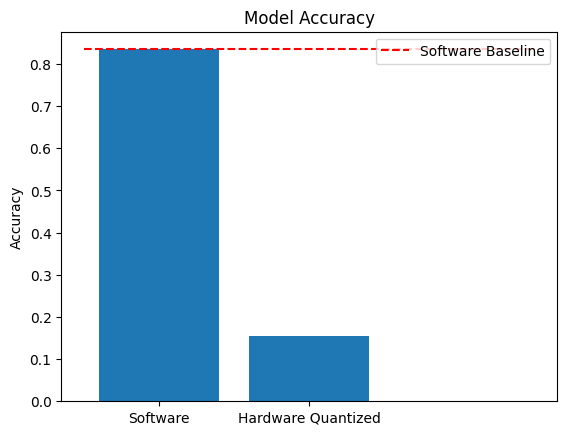

In [9]:
plt.bar(["Software", "Hardware Quantized"], [software_accuracy, hardware_quantized_accuracy])
plt.hlines(software_accuracy, -0.5, 2.5, colors="r", linestyles="dashed", label="Software Baseline")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

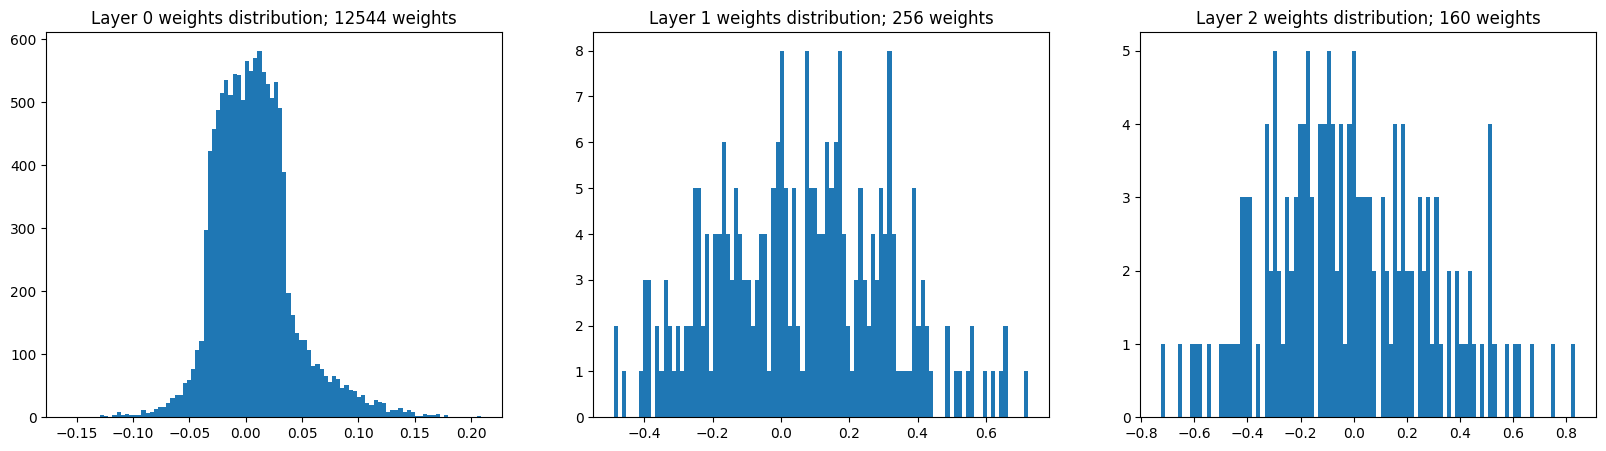

In [ ]:
# plot weight distributions

def plot_weights(model, layer_idx=None):

    if layer_idx is not None:
        for i, layer in enumerate(model.children()):
            if i == layer_idx:
                mylayer = layer
                break

        weights = mylayer.weight.detach().numpy().flatten()
        plt.hist(weights, bins=100)
        plt.title(f"Layer {layer_idx} weights distribution")
        plt.show()

    # side by side comparison
    else:
        total_layers = len(list(model.children()))
        fig, axs = plt.subplots(1, total_layers, figsize=(20, 5))

        for i, layer in enumerate(model.children()):
            weights = layer.weight.detach().numpy().flatten()
            total_weights = len(weights)

            axs[i].hist(weights, bins=100)
            axs[i].set_title(f"Layer {i} weights distribution; {total_weights} weights")


        
        plt.show()

plot_weights(software_nn)